In [251]:
import pandas as pd
import yfinance as yf
from datetime import datetime
from datetime import date,timedelta
import yfinance as yf
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import seaborn as sns
import pandas_ta as ta
import numpy as np
import json
from tkinter import *
from tkinter import messagebox, ttk, END

In [252]:
FONT_NAME = "Courier"
analysis = ['Price', 'Candlestick', 'RSI', 'MACD', 'Bollinger Bands', 'M10&M20', 'ALL']

# Global variable to store the selected analysis
global_selected_analysis = []

# Functions
def send_data():
    global global_selected_analysis  # Use global variable

    ticker = input_ticker.get().upper()
    days = input_time.get()  # Removed int conversion to catch errors more easily
    mail = input_mail.get()

    # Try to convert days to int
    try:
        days = int(days)
    except ValueError:
        messagebox.showwarning(title="Warning", message="Days must be a number")
        return

    new_data = {
        "stock": {
            "ticker": ticker,
            "days": days,
            "mail": mail,
            "analysis": global_selected_analysis
        }
    }

    # Validation checks
    if len(ticker) == 0 or days == 0 or len(mail) == 0:
        messagebox.showwarning(title="Warning", message="Check your data")
    elif len(ticker) >= 8:
        messagebox.showwarning(title="Warning", message='Ticker too long')
    elif days < 1 or days > 720:
        messagebox.showwarning(title="Warning", message='Check your date period')
    elif "@" not in mail or "." not in mail:
        messagebox.showwarning(title="Warning", message='Check your mail')
        return
    else:
        messagebox.showinfo(title="Check your mail", message='Data was sent, close the program or input next ticker.')

    # Save data to file
    try:
        data_file_path = './data/data.json'
        try:
            with open(data_file_path, mode="r") as data_file:
                data = json.load(data_file)
        except json.JSONDecodeError:
            data = {}

        data.update(new_data)

        with open(data_file_path, mode="w") as data_file:
            json.dump(data, data_file, indent=4)

    except Exception as e:
        messagebox.showerror(title="Error", message=f"An error occurred: {e}")
    finally:
        # Clear the input fields
        input_ticker.delete(0, END)
        input_time.delete(0, END)
        input_mail.delete(0, END)

# Function to get selected analysis
def selected_item():
    global global_selected_analysis  # Use global variable
    global_selected_analysis.clear()  # Clear previous selections
    chosen = listbox.curselection()  # Get selected indices
    for v in chosen:
        op = listbox.get(v)  # Get the actual value of the selected item
        global_selected_analysis.append(op)

    print(f"Inside selected_item: {global_selected_analysis}")

# UI
window = Tk()
window.config(padx=25, pady=25)
window.title('Stock Market Analysis')

canvas = Canvas(width=500, height=500, highlightthickness=0)
stock_png = PhotoImage(file='./images/stock_graph.png')
canvas.create_image(250, 250, image=stock_png)
canvas.grid(column=1, row=0)

# Ticker Input
stock = Label(text='Ticker Name', font=(FONT_NAME, 12))
stock.grid(column=0, row=1)

input_ticker = Entry(width=21)
input_ticker.grid(column=1, row=1)

# Time period input
time = Label(text='Time period in days (max 720)', font=(FONT_NAME, 12))
time.grid(column=0, row=2)

input_time = Entry(width=21)
input_time.grid(column=1, row=2)

# Email input
email = Label(text='Write your email', font=(FONT_NAME, 12))
email.grid(column=0, row=3)

input_mail = Entry(width=21)
input_mail.grid(column=1, row=3)

# Analysis selection
analysis_type = Label(text='Choose analysis type', font=(FONT_NAME, 12))
analysis_type.grid(column=0, row=4)

listbox = Listbox(window, selectmode='multiple', exportselection=0, width=21)
listbox.grid(column=1, row=4)

for value in analysis:
    listbox.insert(END, value)

# Button to send data
button = Button(text='Send', command=lambda: [selected_item(), send_data()])  # First get selected item, then send data
button.grid(column=2, row=4)

window.mainloop()

Inside selected_item: ['Price', 'Candlestick', 'RSI', 'MACD', 'Bollinger Bands', 'M10&M20']


2024-09-15 22:23:25.988 python[38662:1853391] Warning: Expected min height of view: (<NSButton: 0x7fa42b7515e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


In [253]:
global_selected_analysis

['Price', 'Candlestick', 'RSI', 'MACD', 'Bollinger Bands', 'M10&M20']

In [254]:
data = pd.read_json('./data/data.json')
print(data)

                                                      stock
ticker                                              BTC-USD
days                                                    700
mail                                mazururrszula@gmail.com
analysis  [Price, Candlestick, RSI, MACD, Bollinger Band...


In [255]:
ticker = data['stock']['ticker']
time = data['stock']['days']

In [256]:
today = date.today()
today = today.strftime('%Y-%m-%d')
start_date = date.today() - timedelta(days=time)
start_date = start_date.strftime('%Y-%m-%d')

In [257]:
ticker = ticker
stock_data = yf.download(ticker, start = start_date, end = today, progress=False)
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-10-16,19068.914062,19389.603516,19068.914062,19268.093750,19268.093750,17988916650
2022-10-17,19268.562500,19635.802734,19173.333984,19550.757812,19550.757812,27472552998
2022-10-18,19550.466797,19666.994141,19144.769531,19334.416016,19334.416016,30580012344
2022-10-19,19335.027344,19348.416016,19127.687500,19139.535156,19139.535156,22425387184
2022-10-20,19138.085938,19315.199219,18971.458984,19053.740234,19053.740234,24493974420
...,...,...,...,...,...,...
2024-09-10,57020.097656,58029.976562,56419.414062,57648.710938,57648.710938,28857630507
2024-09-11,57650.289062,57991.320312,55567.339844,57343.171875,57343.171875,37049062672
2024-09-12,57343.171875,58534.359375,57330.101562,58127.011719,58127.011719,33835707949


In [258]:
#RSI, Garman, ATR, MACD
stock_data['RSI'] = ta.rsi(close = stock_data["Adj Close"], length=14)

stock_data['Garman'] = ((np.log(stock_data['High'])- np.log(stock_data['Low']))**2)/2-(2*np.log(2)-1)*((np.log(stock_data['Adj Close']) -np.log(stock_data['Open']))**2)

def compute_atr(stock_data):
    atr = ta.atr(high=stock_data['High'], low=stock_data['Low'], close=stock_data['Close'], length=14)
    return atr.sub(atr.mean()).div(atr.std())
stock_data['ATR'] = compute_atr(stock_data)

def compute_macd(stock_data):
    macd = ta.macd(close=stock_data['Close'], length = 14).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())
stock_data['MACD'] = compute_macd(stock_data)

today = date.today() 
two_weeks = today - timedelta(days=14)

#Last 14 days
technical_analysis = stock_data.iloc[-14:]
technical_analysis

,Open,High,Low,Close,Adj Close,Volume,RSI,Garman,ATR,MACD
Date,,,,,,,,,,
2024-09-01,58969.800781,59062.070312,57217.824219,57325.488281,57325.488281,24592449997,40.316701,0.000194,1.105223,-0.790218
2024-09-02,57326.968750,59403.070312,57136.027344,59112.480469,59112.480469,27036454524,46.323213,0.000394,1.090175,-0.801727
2024-09-03,59106.191406,59815.058594,57425.167969,57431.023438,57431.023438,26666961053,42.036326,0.000512,1.085550,-0.914764
2024-09-04,57430.347656,58511.570312,55673.164062,57971.539062,57971.539062,35627680312,43.835657,0.001202,1.115386,-0.961453
2024-09-05,57971.703125,58300.582031,55712.453125,56160.488281,56160.488281,31030280656,39.420150,0.000642,1.124046,-1.108667
2024-09-06,56160.191406,56976.109375,52598.699219,53948.753906,53948.753906,49361693566,34.808790,0.002572,1.268246,-1.359040
2024-09-07,53949.085938,54838.144531,53740.070312,54139.687500,54139.687500,19061486526,35.510142,0.000200,1.152599,-1.531015
2024-09-08,54147.933594,55300.859375,53653.757812,54841.566406,54841.566406,18268287531,38.144589,0.000395,1.086991,-1.606356
2024-09-09,54851.886719,58041.125000,54598.433594,57019.535156,57019.535156,34618096173,45.574364,0.001289,1.162709,-1.509062


In [259]:
#Candlestick
fig = go.Figure(data=[go.Candlestick(x=stock_data.index, open = stock_data['Open'], close=stock_data['Close'], high = stock_data['High'], low=stock_data['Low'])])
fig.update_layout(xaxis_rangeslider_visible=False, yaxis_title=f'{ticker} stock', xaxis_title='Date', plot_bgcolor='lightgrey',
                  width=1050, height = 600)
fig.show()
#Save it to the folder
fig.write_image('./images/Candlestick.png')

In [260]:
#Price chart
fig = go.Figure(data=[go.Scatter(x=stock_data.index, y=stock_data['Adj Close'], mode='lines', name='Adj Close')])
fig.update_layout(
    xaxis_rangeslider_visible=False,
    yaxis_title=f'{ticker} Price',
    xaxis_title='Date',
    plot_bgcolor='lightgrey',
    width=1050,
    height=600
)
fig.show()
fig.write_image('./images/Price.png')


In [261]:
#RSI
fig = go.Figure(data=[go.Scatter(x=stock_data.index, y=stock_data['RSI'], mode='lines', name='RSI')])
fig.update_layout(
    xaxis_rangeslider_visible=False,
    yaxis_title=f'{ticker} RSI',
    xaxis_title='Date',
    plot_bgcolor='lightgrey',
    width=1050,
    height=600
)
fig.show()
fig.write_image('./images/RSI.png')

In [262]:
#MACD
fig = go.Figure(data=[go.Scatter(x=stock_data.index, y=stock_data['MACD'], mode='lines', name='MACD')])
fig.update_layout(
    xaxis_rangeslider_visible=False,
    yaxis_title=f'{ticker} MACD',
    xaxis_title='Date',
    plot_bgcolor='lightgrey',
    width=1050,
    height=600
)
fig.show()
fig.write_image('./images/MACD.png')

In [263]:
#MA
stock_data['M10'] = stock_data['Close'].rolling(window=10).mean()
stock_data['M20'] = stock_data['Close'].rolling(window=20).mean()

#Bolinger Bands
stock_data['SD'] = stock_data['Close'].rolling(window=20).std()
# Calculate the Upper Bollinger Band (UB) and Lower Bollinger Band (LB)
stock_data['UB'] = stock_data['M20'] + 2 * stock_data['SD']
stock_data['LB'] = stock_data['M20'] - 2 * stock_data['SD']

In [264]:
#BB
fig = go.Figure()
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['UB'], mode='lines', name='Upper Bollinger Band', visible=True, line=dict(color='red')))
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['LB'], fill='tonexty', mode='lines', name='Lower Bollinger Band', visible=True, line=dict(color='green')))
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['M20'], mode='lines', name='Middle Bollinger Band', visible=True, line=dict(color='blue')))
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['Close'], mode='lines', name='Price (Bollinger)', visible=True, line=dict(color='black')))
fig.update_layout(
    xaxis_rangeslider_visible=False,
    yaxis_title=f'{ticker} Bolinger Bands',
    xaxis_title='Date',
    plot_bgcolor='lightgrey',
    width=1050,
    height=600
)
fig.show()
fig.write_image('./images/Bollinger Bands.png')

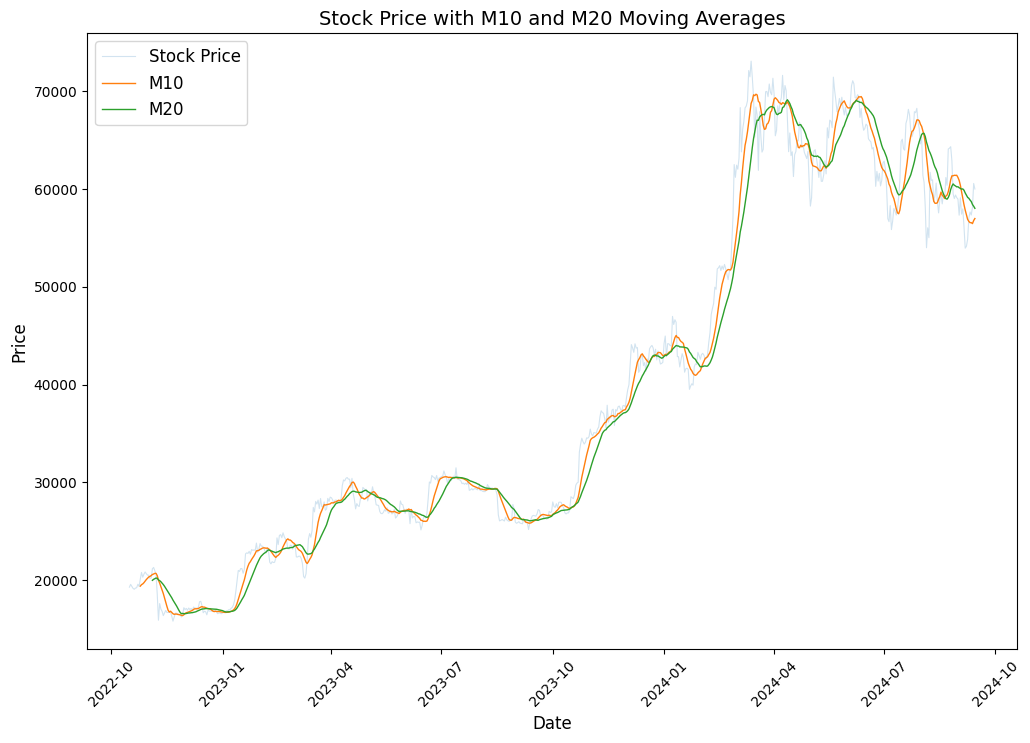

<Figure size 640x480 with 0 Axes>

In [265]:
plt.figure(figsize=(12,8))
plt.plot(stock_data.index, stock_data['Close'], label='Stock Price', linewidth=0.8, alpha=0.2)

plt.plot(stock_data.index, stock_data['M10'], label='M10', linewidth=1, alpha=1)
plt.plot(stock_data.index, stock_data['M20'], label='M20', linewidth=1, alpha=1)

plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.title('Stock Price with M10 and M20 Moving Averages', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.show()
plt.savefig('./images/M10&M20.png')

END ANALYSIS

In [266]:
import os
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

#Send mail to user
email = data['stock']['mail']

def send_analysis_email(global_selected_analysis):
    
    # Email setup
    mail = os.getenv('MAIL')
    password = os.getenv('PASSWORD')
    recipients = email  
    subject = 'Stock Analysis'
    smtp_server = 'smtp.gmail.com'
    smtp_port = 587

    # Create the email message
    msg = MIMEMultipart()
    msg['From'] = mail
    msg['To'] = ', '.join(recipients)
    msg['Subject'] = subject

    body = 'Attached are the graphs for the technical analyses you selected.'
    msg.attach(MIMEText(body, 'plain'))

    folder = './images/'

    # Attach the relevant images
    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            analysis_type = filename[:-4]  # Remove the .png extension
            if analysis_type in global_selected_analysis:
                file_path = os.path.join(folder, filename)
                if os.path.isfile(file_path):
                    try:
                        print(f"Attaching {file_path}")
                        with open(file_path, 'rb') as img_file:
                            img_data = img_file.read()
                            image = MIMEImage(img_data, name=filename)
                            msg.attach(image)
                    except Exception as e:
                        print(f"Error processing file {file_path}: {e}")
                else:
                    print(f"File not found: {file_path}")

    # Send the email
    try:
        with smtplib.SMTP(smtp_server, smtp_port) as connection:
            connection.starttls()
            connection.login(user=mail, password=password)
            connection.sendmail(
                from_addr=mail,
                to_addrs=recipients,
                msg=msg.as_string()
            )
        print('Email with images was sent successfully!')
    except Exception as e:
        print(f"Error sending email: {e}")

send_analysis_email(global_selected_analysis)


Attaching ./images/Bollinger Bands.png
Attaching ./images/Price.png
Attaching ./images/MACD.png
Attaching ./images/M10&M20.png
Attaching ./images/Candlestick.png
Attaching ./images/RSI.png
Email with images was sent successfully!
